# Workbook for working thru the Data Science Pipeline

**Plan** > Acquire > Prepare > Model > Deliver

**What is driving telco customers to churn?**
- Target variable is Churn ==> Categorical

- Are there features that make a customer more likely to churn or not churn?
    - Null Hypothesis: Features have no predictive value over whether a customer churns or not. 
    - Alt Hypothesis: Certain features can help predict whether a customer will churn or not. 
    
- Goal 1: Identify predictve features (if any) and build a model for predicting churn at Telco
 
- Goal 2: Propose reccomendations for reducing churn based upon analysis

In [34]:
#Imports

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#standard imports
import numpy as np
import pandas as pd
import os

#visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

#env & modules
from env import host, user, password
import acquire
import prepare
import explore

In [24]:
#define get_connection to be used in acquire.py file 
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the CodeUp db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [25]:
#define acquire telco data function
def get_telco_data():
    '''
    This function reads in telco data from Codeup database and writes data to
    a csv file, returns df.
    '''
  # filename = 'telco.csv'
  # if os.path.isfile(filename):
  #     return pd.read_csv(filename)
  # else:
  #     # Read fresh data from db into a DataFrame.
    df = pd.read_sql('''
            SELECT *
FROM customers
JOIN internet_service_types USING (internet_service_type_id)
JOIN contract_types USING(contract_type_id)
JOIN payment_types USING (payment_type_id);
            ''', 
            get_connection('telco_churn'))
        
        # Write DataFrame to a csv file.
       # df.to_csv(filename)
          
    return df

In [42]:
telco = get_telco_data()

In [43]:
telco.tail()

payment_type_id  contract_type_id  internet_service_type_id customer_id  \
7038                4                 3                         3  9950-MTGYX   
7039                2                 3                         3  9953-ZMKSM   
7040                4                 3                         3  9964-WBQDJ   
7041                3                 3                         3  9972-EWRJS   
7042                4                 3                         3  9975-GPKZU   

      gender  senior_citizen partner dependents  tenure phone_service  ...  \
7038    Male               0     Yes        Yes      28           Yes  ...   
7039    Male               0      No         No      63           Yes  ...   
7040  Female               0     Yes         No      71           Yes  ...   
7041  Female               0     Yes        Yes      67           Yes  ...   
7042    Male               0     Yes        Yes      46           Yes  ...   

             tech_support         streaming_tv     streaming_movies  \
7038  No internet service  No internet service  No internet service   
7039  No internet service  No internet service  No internet service   
7040  No internet service  No internet service  No internet service   
7041  No internet service  No internet service  No internet service   
7042  No internet service  No internet service  No internet service   

     paperless_billing monthly_charges total_charges churn  \
7038               Yes           20.30        487.95    No   
7039                No           25.25        1559.3    No   
7040               Yes           24.40        1725.4    No   
7041               Yes           19.25        1372.9    No   
7042                No           19.75         856.5    No   

     internet_service_type  contract_type               payment_type  
7038                  None       Two year    Credit card (automatic)  
7039                  None       Two year               Mailed check  
7040                  None       Two year    Credit card (automatic)  
7041                  None       Two year  Bank transfer (automatic)  
7042                  None       Two year    Credit card (automatic)  

[5 rows x 24 columns]

In [56]:
telco.payment_type_id.replace({1: 0, 2: 0, 3: 1, 4: 1}, inplace=True)

In [57]:
telco.rename(columns={'payment_type_id': 'auto_bill_pay'}, inplace=True)

In [58]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   auto_bill_pay             7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [20]:
telco.internet_service_type.value_counts(normalize=True)

Fiber optic    0.439585
DSL            0.343746
None           0.216669
Name: internet_service_type, dtype: float64

In [21]:
telco.contract_type.value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: contract_type, dtype: float64

In [22]:
telco.payment_type.value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_type, dtype: float64

In [48]:
telco.total_charges = telco.total_charges.replace(' ', 0.0)
telco.total_charges = telco.total_charges.astype('float64')

In [49]:
telco['total_charges'].replace(0,telco['monthly_charges'],inplace=True)



ValueError: Series.replace cannot use dict-value and non-None to_replace

In [98]:

telco['total_charges_1'] = telco.total_charges.apply(lambda n: n if n > 0 else n.replace(telco.monthly_charges[n]))

AttributeError: 'float' object has no attribute 'replace'

In [96]:
telco.tail()

Unnamed: 0 customer_id gender  senior_citizen partner dependents  \
253543      253543  9995-HOTOH   Male               0     Yes        Yes   
253544      253544  9995-HOTOH   Male               0     Yes        Yes   
253545      253545  9995-HOTOH   Male               0     Yes        Yes   
253546      253546  9995-HOTOH   Male               0     Yes        Yes   
253547      253547  9995-HOTOH   Male               0     Yes        Yes   

        tenure phone_service    multiple_lines  internet_service_type_id  ...  \
253543      63            No  No phone service                         1  ...   
253544      63            No  No phone service                         1  ...   
253545      63            No  No phone service                         1  ...   
253546      63            No  No phone service                         1  ...   
253547      63            No  No phone service                         1  ...   

       monthly_charges total_charges churn internet_service_type_id.1  \
253543            59.0        3707.6    No                          2   
253544            59.0        3707.6    No                          3   
253545            59.0        3707.6    No                          1   
253546            59.0        3707.6    No                          2   
253547            59.0        3707.6    No                          3   

       internet_service_type contract_type_id.1  contract_type  \
253543           Fiber optic                  2       One year   
253544                  None                  2       One year   
253545                   DSL                  3       Two year   
253546           Fiber optic                  3       Two year   
253547                  None                  3       Two year   

       payment_type_id.1             payment_type  total_charges_1  
253543                 4  Credit card (automatic)           3707.6  
253544                 4  Credit card (automatic)           3707.6  
253545                 4  Credit card (automatic)           3707.6  
253546                 4  Credit card (automatic)           3707.6  
253547                 4  Credit card (automatic)           3707.6  

[5 rows x 29 columns]

In [101]:
def update_total_charges(df):
    for n in df.total_charges:
        if n == 0:
            data.replace({
            'total_charges': {
        '0: 'monthly_charges'
                        }
                        })
        else:
            n == n
    return df

SyntaxError: invalid syntax (<ipython-input-101-85d878c3feba>, line 6)

In [102]:
telco['total_charges'] = np.where(telco['total_charges']==0, telco['monthly_charges'] , telco['total_charges'])

In [109]:
telco[telco.tenure > 1].sample(10)

Unnamed: 0 customer_id  gender  senior_citizen partner dependents  \
163134      163134  6383-ZTSIW  Female               1     Yes         No   
116436      116436  4632-PAOYU    Male               0     Yes        Yes   
12954        12954  0529-ONKER    Male               1      No         No   
15149        15149  0620-XEFWH    Male               0     Yes        Yes   
123250      123250  4851-BQDNX    Male               0     Yes        Yes   
31781        31781  1273-MTETI  Female               1      No         No   
20573        20573  0840-DCNZE    Male               0      No         No   
7883          7883  0334-ZFJSR  Female               0     Yes         No   
209852      209852  8204-TIFGJ  Female               0      No         No   
44988        44988  1848-LBZHY  Female               0     Yes         No   

        tenure phone_service multiple_lines  internet_service_type_id  ...  \
163134      39           Yes             No                         2  ...   
116436      22           Yes             No                         3  ...   
12954       15           Yes            Yes                         2  ...   
15149        4           Yes             No                         3  ...   
123250      40           Yes             No                         2  ...   
31781        4           Yes            Yes                         2  ...   
20573       47           Yes             No                         1  ...   
7883        55           Yes            Yes                         1  ...   
209852      23           Yes             No                         3  ...   
44988        7           Yes             No                         1  ...   

       monthly_charges total_charges churn internet_service_type_id.1  \
163134           99.10       3877.95    No                          1   
116436           19.95        433.50    No                          1   
12954            75.65       1146.65   Yes                          1   
15149            18.85         84.20    No                          3   
123250           85.05       3355.65    No                          2   
31781            88.85        372.45   Yes                          3   
20573            86.95       4138.90    No                          3   
7883             66.05       3462.10    No                          3   
209852           20.30        470.60    No                          3   
44988            50.30        355.10    No                          1   

       internet_service_type contract_type_id.1   contract_type  \
163134                   DSL                  1  Month-to-month   
116436                   DSL                  2        One year   
12954                    DSL                  2        One year   
15149                   None                  1  Month-to-month   
123250           Fiber optic                  2        One year   
31781                   None                  1  Month-to-month   
20573                   None                  3        Two year   
7883                    None                  3        Two year   
209852                  None                  3        Two year   
44988                    DSL                  3        Two year   

       payment_type_id.1               payment_type  total_charges_1  
163134                 3  Bank transfer (automatic)          3877.95  
116436                 2               Mailed check            433.5  
12954                  4    Credit card (automatic)          1146.65  
15149                  4    Credit card (automatic)             84.2  
123250                 3  Bank transfer (automatic)          3355.65  
31781                  4    Credit card (automatic)           372.45  
20573                  2               Mailed check           4138.9  
7883                   4    Credit card (automatic)           3462.1  
209852                 1           Electronic check            470.6  
44988                  3  Bank transfer (automati

In [110]:
telco.total_charges.describe()

count    253548.000000
mean       2279.798992
std        2266.573713
min          18.800000
25%         398.550000
50%        1394.550000
75%        3789.200000
max        8684.800000
Name: total_charges, dtype: float64

In [27]:
telco.loc[telco[telco.total_charges == 0.0]] = telco.loc[telco[telco.monthly_charges]]

KeyError: "None of [Float64Index([65.6, 65.6, 65.6, 65.6, 65.6, 65.6, 65.6, 65.6, 65.6, 65.6,\n              ...\n              59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59.0, 59.0],\n             dtype='float64', length=253548)] are in the [columns]"

In [103]:
telco[telco.total_charges == 0].tail()

Empty DataFrame
Columns: [Unnamed: 0, customer_id, gender, senior_citizen, partner, dependents, tenure, phone_service, multiple_lines, internet_service_type_id, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, contract_type_id, paperless_billing, payment_type_id, monthly_charges, total_charges, churn, internet_service_type_id.1, internet_service_type, contract_type_id.1, contract_type, payment_type_id.1, payment_type, total_charges_1]
Index: []

[0 rows x 29 columns]

In [ ]:
#Check the distribution of senior citizens

<AxesSubplot:xlabel='senior_citizen', ylabel='Count'>

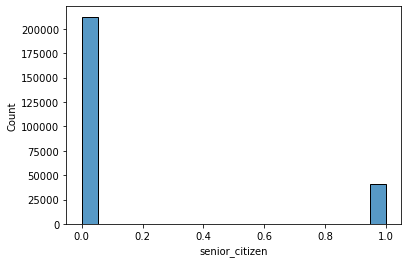

In [6]:
sns.histplot(data=telco.senior_citizen)

In [12]:
telco.describe()

senior_citizen         tenure  internet_service_type_id  \
count   253548.000000  253548.000000             253548.000000   
mean         0.162147      32.371149                  1.872923   
std          0.368586      24.557786                  0.737745   
min          0.000000       0.000000                  1.000000   
25%          0.000000       9.000000                  1.000000   
50%          0.000000      29.000000                  2.000000   
75%          0.000000      55.000000                  2.000000   
max          1.000000      72.000000                  3.000000   

       contract_type_id  payment_type_id  monthly_charges  \
count     253548.000000    253548.000000    253548.000000   
mean           1.690473         2.315633        64.761692   
std            0.833698         1.148828        30.087970   
min            1.000000         1.000000        18.250000   
25%            1.000000         1.000000        35.500000   
50%            1.000000         2.000000        70.350000   
75%            2.000000         3.000000        89.850000   
max            3.000000         4.000000       118.750000   

       internet_service_type_id  contract_type_id  payment_type_id  
count             253548.000000     253548.000000    253548.000000  
mean                   2.000000          2.000000         2.500000  
std                    0.816498          0.816498         1.118036  
min                    1.000000          1.000000         1.000000  
25%                    1.000000          1.000000         1.750000  
50%                    2.000000          2.000000         2.500000  
75%                    3.000000          3.000000         3.250000  
max                    3.000000          3.000000         4.000000

In [40]:
#Make a list of all the columns
cols = telco.columns.to_list()
cols

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service_type_id',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract_type_id',
 'paperless_billing',
 'payment_type_id',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type_id',
 'internet_service_type',
 'contract_type_id',
 'contract_type',
 'payment_type_id',
 'payment_type']

In [42]:
#List of all numeric columns 
telco.select_dtypes(include='int64').columns.to_list()

['senior_citizen',
 'tenure',
 'internet_service_type_id',
 'contract_type_id',
 'payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'payment_type_id']

In [43]:
#Range for all numeic columns
telco_numeric_columns = telco.select_dtypes(include=[np.number])
df_column_range = telco_numeric_columns.max() - telco_numeric_columns.min()
df_column_range

senior_citizen                1.0
tenure                       72.0
internet_service_type_id      2.0
contract_type_id              2.0
payment_type_id               3.0
monthly_charges             100.5
internet_service_type_id      2.0
contract_type_id              2.0
payment_type_id               3.0
dtype: float64

In [46]:
#List of all non numeric columns 
telco.select_dtypes(include='object').columns.to_list()

['customer_id',
 'gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'total_charges',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type']

### Takeaways:
- tenure and monthly charges are the only continuous variables
- duplicate columns exist and will need to be handled

In [123]:
telco.internet_service_type.value_counts()

None           84516
DSL            84516
Fiber optic    84516
Name: internet_service_type, dtype: int64

### Steps for Prepare:
- Replace all Yes and No values with 0, 1
- Encode gender, internet_service_type, contract_type, payment_type
- Drop  gender, internet_service_type, internet_service_type_id, contract_type_id, payment_type_id 
- Replace No phone service with No
- Replace No Internet Service with No
- Deal with missing values in total charges - Create a function for this

In [136]:
telco.replace({'No internet service': 'No', 'No phone service':'No'}, inplace=True)

In [137]:
telco.replace({'Yes': 1, 'No': 0}, inplace=True)

In [138]:
cols_to_drop = ['internet_service_type_id', 'contract_type_id', 'payment_type_id']
telco.drop(columns=cols_to_drop, inplace=True)

In [58]:
telco.select_dtypes(include='object').columns.to_list()

['customer_id',
 'gender',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

In [139]:
cols_to_encode = ['gender', 'contract_type', 'payment_type' ]

In [140]:
dummies = pd.get_dummies(telco[cols_to_encode], drop_first=[True])

In [141]:
dummies

gender_Male  contract_type_One year  contract_type_Two year  \
0                 0                       0                       0   
1                 0                       0                       0   
2                 0                       0                       0   
3                 0                       1                       0   
4                 0                       1                       0   
...             ...                     ...                     ...   
253543            1                       1                       0   
253544            1                       1                       0   
253545            1                       0                       1   
253546            1                       0                       1   
253547            1                       0                       1   

        payment_type_Credit card (automatic)  payment_type_Electronic check  \
0                                          0                              1   
1                                          0                              1   
2                                          0                              1   
3                                          0                              1   
4                                          0                              1   
...                                      ...                            ...   
253543                                     1                              0   
253544                                     1                              0   
253545                                     1                              0   
253546                                     1                              0   
253547                                     1                              0   

        payment_type_Mailed check  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
...                           ...  
253543                          0  
253544                          0  
253545                          0  
253546                          0  
253547                          0  

[253548 rows x 6 columns]

In [142]:
telco = pd.concat([telco, dummies], axis=1)

In [143]:
telco.head()

Unnamed: 0 customer_id  gender  senior_citizen  partner  dependents  \
0           0  0002-ORFBO  Female               0        1           1   
1           1  0002-ORFBO  Female               0        1           1   
2           2  0002-ORFBO  Female               0        1           1   
3           3  0002-ORFBO  Female               0        1           1   
4           4  0002-ORFBO  Female               0        1           1   

   tenure  phone_service  multiple_lines  online_security  ...  \
0       9              1               0                0  ...   
1       9              1               0                0  ...   
2       9              1               0                0  ...   
3       9              1               0                0  ...   
4       9              1               0                0  ...   

   contract_type_id.1   contract_type  payment_type_id.1      payment_type  \
0                   1  Month-to-month                  1  Electronic check   
1                   1  Month-to-month                  1  Electronic check   
2                   1  Month-to-month                  1  Electronic check   
3                   2        One year                  1  Electronic check   
4                   2        One year                  1  Electronic check   

   gender_Male  contract_type_One year  contract_type_Two year  \
0            0                       0                       0   
1            0                       0                       0   
2            0                       0                       0   
3            0                       1                       0   
4            0                       1                       0   

  payment_type_Credit card (automatic)  payment_type_Electronic check  \
0                                    0                              1   
1                                    0                              1   
2                                    0                              1   
3                                    0                              1   
4                                    0                              1   

   payment_type_Mailed check  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  

[5 rows x 31 columns]

In [144]:
telco.drop(columns={'gender','internet_service_type', 'contract_type', 'payment_type'}, inplace=True)

In [145]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253548 entries, 0 to 253547
Data columns (total 27 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            253548 non-null  int64  
 1   customer_id                           253548 non-null  object 
 2   senior_citizen                        253548 non-null  int64  
 3   partner                               253548 non-null  int64  
 4   dependents                            253548 non-null  int64  
 5   tenure                                253548 non-null  int64  
 6   phone_service                         253548 non-null  int64  
 7   multiple_lines                        253548 non-null  int64  
 8   online_security                       253548 non-null  int64  
 9   online_backup                         253548 non-null  int64  
 10  device_protection                     253548 non-null  int64  
 11  

### Questions:
- Are there really no nulls in this dataframe?
- Why is the dtype for total_charges an object?
- Should reset index to be customer_id..if all ids are unique

In [76]:
#Are all the customers ids unique? 
telco['customer_id'].nunique()

7043

In [146]:
#Drop customer id
telco.drop(columns='customer_id', inplace=True)

In [97]:
telco.total_charges.astype('float64', errors='raise')

ValueError: could not convert string to float: ''

In [155]:
#Telco total charges with missing values are all related to the fact that tenure is less than 1 month - so total charges are 0
telco.tenure[telco.total_charges == ' '].nunique()

1

In [163]:
#fill those values
telco.total_charges = telco.total_charges.replace(' ', 0.0)

In [164]:
#Convert total_charges to float
telco.total_charges = telco.total_charges.astype('float64', errors='raise')

In [165]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253548 entries, 0 to 253547
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            253548 non-null  int64  
 1   senior_citizen                        253548 non-null  int64  
 2   partner                               253548 non-null  int64  
 3   dependents                            253548 non-null  int64  
 4   tenure                                253548 non-null  int64  
 5   phone_service                         253548 non-null  int64  
 6   multiple_lines                        253548 non-null  int64  
 7   online_security                       253548 non-null  int64  
 8   online_backup                         253548 non-null  int64  
 9   device_protection                     253548 non-null  int64  
 10  tech_support                          253548 non-null  int64  
 11  

In [156]:
#telco.multiple_lines.astype('float64', errors='raise')

In [157]:
#replace "no phone service" with 0 
#telco.phone_service = telco.phone_service.replace('No phone service ', 0)

In [158]:
#telco.phone_service.astype('int64', errors='raise')

In [159]:
#telco.multiple_lines = telco.multiple_lines.replace('No phone service', 0)

In [160]:
#telco.multiple_lines = telco.multiple_lines.astype('int64', errors='raise')

In [161]:
#telco.info()

In [119]:
#def clean_feature_columns(col):
#    for n in col:
#        if n != 1:
#            n == 0
#    return n

In [122]:
#telco.online_security = clean_feature_columns(telco.online_security)

1

## Testing Different Encoding Method

In [26]:
telco = get_telco_data()

In [27]:
def prep_data(df):
    '''
    This function takes in the telco data frame and prepares it for analysis by:


    '''
    #Convert strings in features that do not match "yes" or "no"
    df.replace({'No internet service': 'No', 'No phone service':'No'}, inplace=True)

    #Convert features with yes or no to 0s and 1s
    df.replace({'Yes': 1, 'No': 0}, inplace=True)

    #Columns to encode
    cols_to_encode = ['gender']

    #Encode
    dummies = pd.get_dummies(df[cols_to_encode], drop_first=[True])

    #Concat dummies to original df
    df = pd.concat([df, dummies], axis=1)

    #Columns to drop
    cols_to_drop = ['contract_type', 'payment_type', 'internet_service_type', 
    'gender','customer_id']

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)

    #Fill empty values in total_charges column where tenure is less than 1 month
    df.total_charges = df.total_charges.replace(' ', 0.0)

    #Convert total_charges to float
    df.total_charges = df.total_charges.astype('float64')

    #Replace 0s in total charges with monthly charge
    df.total_charges = np.where(df.total_charges==0.0, df.monthly_charges , df.total_charges)

    return df


In [28]:
telco = prep_data(telco)

In [29]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   int64  
 5   dependents                7043 non-null   int64  
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   int64  
 8   multiple_lines            7043 non-null   int64  
 9   online_security           7043 non-null   int64  
 10  online_backup             7043 non-null   int64  
 11  device_protection         7043 non-null   int64  
 12  tech_support              7043 non-null   int64  
 13  streaming_tv              7043 non-null   int64  
 14  streamin

In [30]:
telco.head()

payment_type_id  contract_type_id  internet_service_type_id  \
0                2                 1                         1   
1                4                 1                         1   
2                1                 1                         1   
3                1                 1                         1   
4                3                 1                         1   

   senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  \
0               0        0           0       9              1               1   
1               0        0           1       9              1               0   
2               1        0           0       7              1               0   
3               1        0           0       1              0               0   
4               0        1           1       1              0               0   

   online_security  online_backup  device_protection  tech_support  \
0                0              0                  0             0   
1                0              0                  0             1   
2                1              0                  0             0   
3                0              0                  0             0   
4                1              0                  0             0   

   streaming_tv  streaming_movies  paperless_billing  monthly_charges  \
0             0                 1                  0             59.9   
1             1                 1                  1             69.4   
2             0                 0                  1             48.2   
3             0                 0                  1             25.1   
4             0                 0                  0             30.5   

   total_charges  churn  gender_Male  
0         542.40      0            1  
1         571.45      0            0  
2         340.35      0            0  
3          25.10      1            1  
4          30.50      1            0

In [31]:
telco.describe()

payment_type_id  contract_type_id  internet_service_type_id  \
count      7043.000000       7043.000000               7043.000000   
mean          2.315633          1.690473                  1.872923   
std           1.148907          0.833755                  0.737796   
min           1.000000          1.000000                  1.000000   
25%           1.000000          1.000000                  1.000000   
50%           2.000000          1.000000                  2.000000   
75%           3.000000          2.000000                  2.000000   
max           4.000000          3.000000                  3.000000   

       senior_citizen      partner   dependents       tenure  phone_service  \
count     7043.000000  7043.000000  7043.000000  7043.000000    7043.000000   
mean         0.162147     0.483033     0.299588    32.371149       0.903166   
std          0.368612     0.499748     0.458110    24.559481       0.295752   
min          0.000000     0.000000     0.000000     0.000000       0.000000   
25%          0.000000     0.000000     0.000000     9.000000       1.000000   
50%          0.000000     0.000000     0.000000    29.000000       1.000000   
75%          0.000000     1.000000     1.000000    55.000000       1.000000   
max          1.000000     1.000000     1.000000    72.000000       1.000000   

       multiple_lines  online_security  online_backup  device_protection  \
count     7043.000000      7043.000000    7043.000000        7043.000000   
mean         0.421837         0.286668       0.344881           0.343888   
std          0.493888         0.452237       0.475363           0.475038   
min          0.000000         0.000000       0.000000           0.000000   
25%          0.000000         0.000000       0.000000           0.000000   
50%          0.000000         0.000000       0.000000           0.000000   
75%          1.000000         1.000000       1.000000           1.000000   
max          1.000000         1.000000       1.000000           1.000000   

       tech_support  streaming_tv  streaming_movies  paperless_billing  \
count   7043.000000   7043.000000       7043.000000        7043.000000   
mean       0.290217      0.384353          0.387903           0.592219   
std        0.453895      0.486477          0.487307           0.491457   
min        0.000000      0.000000          0.000000           0.000000   
25%        0.000000      0.000000          0.000000           0.000000   
50%        0.000000      0.000000          0.000000           1.000000   
75%        1.000000      1.000000          1.000000           1.000000   
max        1.000000      1.000000          1.000000           1.000000   

       monthly_charges  total_charges        churn  gender_Male  
count      7043.000000    7043.000000  7043.000000  7043.000000  
mean         64.761692    2279.798992     0.265370     0.504756  
std          30.090047    2266.730170     0.441561     0.500013  
min          18.250000      18.800000     0.000000     0.000000  
25%          35.500000     398.550000     0.000000     0.000000  
50%          70.350000    1394.550000     0.000000     1.000000  
75%          89.850000    3786.600000     1.000000     1.000000  
max         118.750000    8684.800000     1.000000     1.000000

In [32]:
cat_vars = ['churn', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines','online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'paperless_billing',
       'internet_service_type_id','gender_Male', 'contract_type_id', 
       'payment_type_id']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']

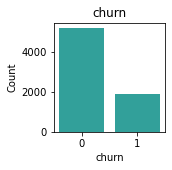

   churn  Count  Percent
0      0   5174    73.46
1      1   1869    26.54
_________________________________________________________________


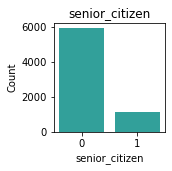

   senior_citizen  Count  Percent
0               0   5901    83.79
1               1   1142    16.21
_________________________________________________________________


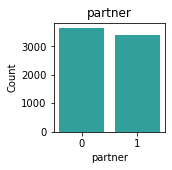

   partner  Count  Percent
0        0   3641     51.7
1        1   3402     48.3
_________________________________________________________________


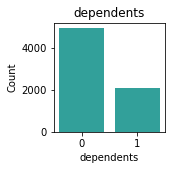

   dependents  Count  Percent
0           0   4933    70.04
1           1   2110    29.96
_________________________________________________________________


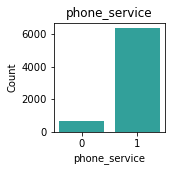

   phone_service  Count  Percent
1              1   6361    90.32
0              0    682     9.68
_________________________________________________________________


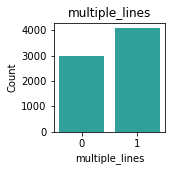

   multiple_lines  Count  Percent
0               1   4072    57.82
1               0   2971    42.18
_________________________________________________________________


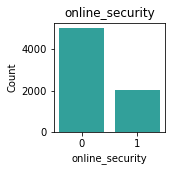

   online_security  Count  Percent
0                0   5024    71.33
1                1   2019    28.67
_________________________________________________________________


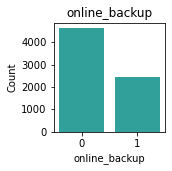

   online_backup  Count  Percent
0              0   4614    65.51
1              1   2429    34.49
_________________________________________________________________


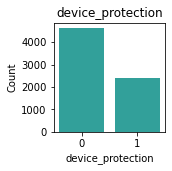

   device_protection  Count  Percent
0                  0   4621    65.61
1                  1   2422    34.39
_________________________________________________________________


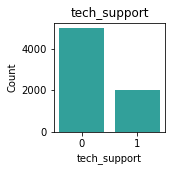

   tech_support  Count  Percent
0             0   4999    70.98
1             1   2044    29.02
_________________________________________________________________


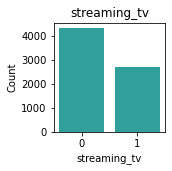

   streaming_tv  Count  Percent
0             0   4336    61.56
1             1   2707    38.44
_________________________________________________________________


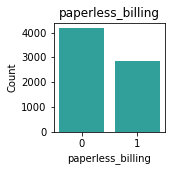

   paperless_billing  Count  Percent
1                  0   4171    59.22
0                  1   2872    40.78
_________________________________________________________________


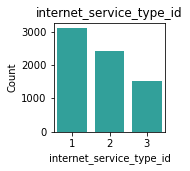

   internet_service_type_id  Count  Percent
2                         1   3096    43.96
1                         2   2421    34.37
3                         3   1526    21.67
_________________________________________________________________


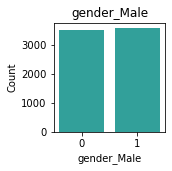

   gender_Male  Count  Percent
1            1   3555    50.48
0            0   3488    49.52
_________________________________________________________________


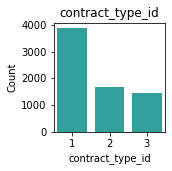

   contract_type_id  Count  Percent
1                 1   3875    55.02
3                 2   1695    24.07
2                 3   1473    20.91
_________________________________________________________________


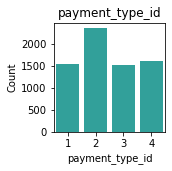

   payment_type_id  Count  Percent
1                2   2365    33.58
2                4   1612    22.89
3                1   1544    21.92
4                3   1522    21.61
_________________________________________________________________


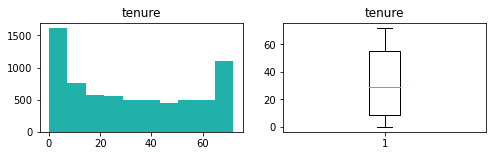

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


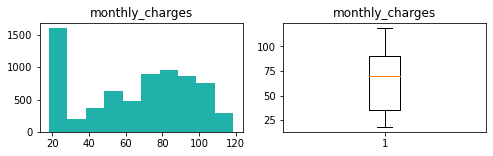

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


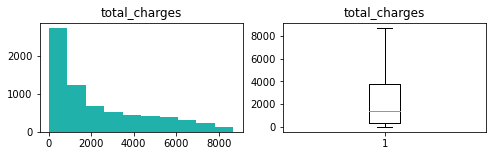

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64


In [35]:
explore.explore_univariate(telco, cat_vars, quant_vars)

In [38]:
#Step 1 is to split the data into my train, validate, and test data frames:
train, validate, test = explore.train_validate_test_split(telco, target='churn', seed=123)

In [39]:
cat_vars = cat_vars[1:]

partner 
_____________________

        chi2       p-value  degrees of freedom
0  59.095958  1.501674e-14                   1

observed:
 churn       0     1   All
partner                  
0        1383   645  2028
1        1514   401  1915
All      2897  1046  3943

expected:
              0           1
0  1490.011666  537.988334
1  1406.988334  508.011666


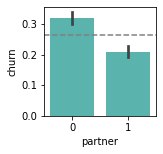


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  104.078831  1.944245e-24                   1

observed:
 churn          0     1   All
dependents                  
0           1887   859  2746
1           1010   187  1197
All         2897  1046  3943

expected:
              0           1
0  2017.540451  728.459549
1   879.459549  317.540451


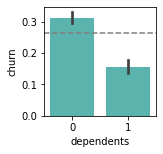


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.031921  0.858201                   1

observed:
 churn             0     1   All
phone_service                  
0               276    97   373
1              2621   949  3570
All            2897  1046  3943

expected:
              0           1
0   274.050469   98.949531
1  2622.949531  947.050469


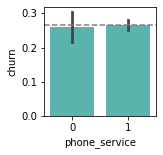


_____________________

multiple_lines 
_____________________

       chi2   p-value  degrees of freedom
0  4.242562  0.039423                   1

observed:
 churn              0     1   All
multiple_lines                  
0               1698   574  2272
1               1199   472  1671
All             2897  1046  3943

expected:
              0           1
0  1669.283287  602.716713
1  1227.716713  443.283287


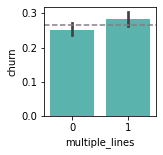


_____________________

online_security 
_____________________

        chi2       p-value  degrees of freedom
0  91.853993  9.331342e-22                   1

observed:
 churn               0     1   All
online_security                  
0                1940   865  2805
1                 957   181  1138
All              2897  1046  3943

expected:
              0           1
0  2060.888917  744.111083
1   836.111083  301.888917


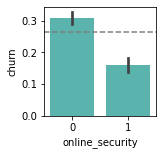


_____________________

online_backup 
_____________________

        chi2   p-value  degrees of freedom
0  20.992487  0.000005                   1

observed:
 churn             0     1   All
online_backup                  
0              1863   755  2618
1              1034   291  1325
All            2897  1046  3943

expected:
              0           1
0  1923.496323  694.503677
1   973.503677  351.496323


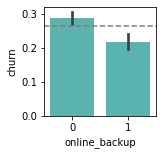


_____________________

device_protection 
_____________________

        chi2   p-value  degrees of freedom
0  17.652315  0.000027                   1

observed:
 churn                 0     1   All
device_protection                  
0                  1865   749  2614
1                  1032   297  1329
All                2897  1046  3943

expected:
              0           1
0  1920.557444  693.442556
1   976.442556  352.557444


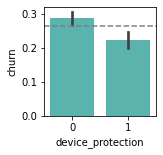


_____________________

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  111.221776  5.290815e-26                   1

observed:
 churn            0     1   All
tech_support                  
0             1941   881  2822
1              956   165  1121
All           2897  1046  3943

expected:
              0           1
0  2073.379153  748.620847
1   823.620847  297.379153


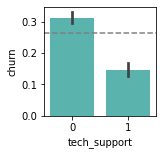


_____________________

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  17.559103  0.000028                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1854   592  2446
1             1043   454  1497
All           2897  1046  3943

expected:
              0           1
0  1797.124524  648.875476
1  1099.875476  397.124524


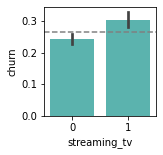


_____________________

paperless_billing 
_____________________

         chi2       p-value  degrees of freedom
0  142.836865  6.381161e-33                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1359   268  1627
1                  1538   778  2316
All                2897  1046  3943

expected:
              0           1
0  1195.389044  431.610956
1  1701.610956  614.389044


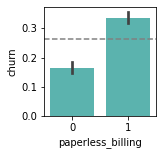


_____________________

internet_service_type_id 
_____________________

         chi2       p-value  degrees of freedom
0  405.080731  1.091031e-88                   2

observed:
 churn                        0     1   All
internet_service_type_id                  
1                         1077   260  1337
2                         1018   725  1743
3                          802    61   863
All                       2897  1046  3943

expected:
              0           1
0   982.320314  354.679686
1  1280.616536  462.383464
2   634.063150  228.936850


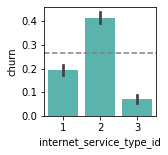


_____________________

gender_Male 
_____________________

       chi2   p-value  degrees of freedom
0  0.927191  0.335594                   1

observed:
 churn           0     1   All
gender_Male                  
0            1473   513  1986
1            1424   533  1957
All          2897  1046  3943

expected:
              0           1
0  1459.153436  526.846564
1  1437.846564  519.153436


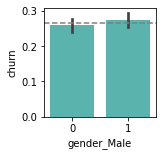


_____________________

contract_type_id 
_____________________

         chi2        p-value  degrees of freedom
0  625.295741  1.654837e-136                   2

observed:
 churn                0     1   All
contract_type_id                  
1                 1269   919  2188
2                  730   103   833
3                  898    24   922
All               2897  1046  3943

expected:
              0           1
0  1607.566827  580.433173
1   612.021557  220.978443
2   677.411616  244.588384


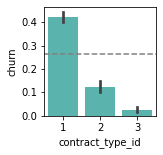


_____________________

payment_type_id 
_____________________

         chi2       p-value  degrees of freedom
0  365.297942  7.261184e-79                   3

observed:
 churn               0     1   All
payment_type_id                  
1                 735   606  1341
2                 738   157   895
3                 699   154   853
4                 725   129   854
All              2897  1046  3943

expected:
             0           1
0  985.259194  355.740806
1  657.574182  237.425818
2  626.715952  226.284048
3  627.450672  226.549328


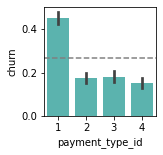


_____________________

tenure 
____________________



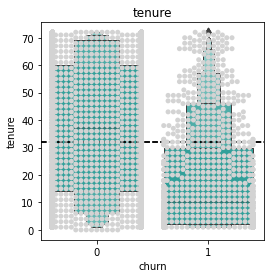

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2897.0  37.021056  24.067195  0.0  14.0  37.0  60.0  72.0
1      1046.0  18.228489  19.391963  1.0   2.0  10.0  30.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2215778.5, pvalue=2.6225178502743525e-109)

____________________

monthly_charges 
____________________



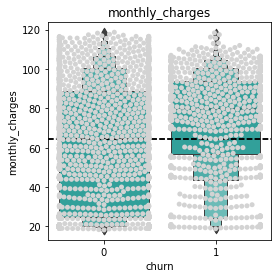

        count       mean        std    min      25%    50%      75%     max
churn                                                                      
0      2897.0  61.176976  31.293724  18.25  25.0500  64.35  88.9500  118.65
1      1046.0  74.376052  24.624883  18.85  56.8125  79.50  94.0375  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1149040.0, pvalue=4.103131725466243e-31)

____________________

total_charges 
____________________



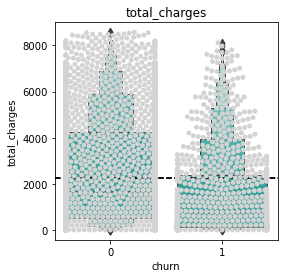

        count         mean          std    min       25%      50%        75%  \
churn                                                                          
0      2897.0  2521.965412  2334.005662  18.80  538.2000  1640.00  4250.1000   
1      1046.0  1538.818499  1856.338676  18.85  139.3625   768.05  2386.1125   

           max  
churn           
0      8564.75  
1      8109.80   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1944421.5, pvalue=3.84641772859757e-42)

____________________



In [40]:
#Explore the bivariate variables
explore.explore_bivariate(train,'churn', cat_vars, quant_vars)